In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys
from tqdm import tqdm
from datetime import datetime

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm

from autoencoder import Autoencoder
from solver import train_vali_all_epochs, dev_train_vali_all_epochs, test

In [28]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [29]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-11-13_14-43-27/


In [30]:
from solver import size_per_epoch, develope_AE, train

model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)
device = torch.device('cuda')

n_epochs = 20
d_explained_variance_ratios = []
d_latent_matrices = []

size_ls = [4,10,16,32]
manner = 'cell_division'

def dev_train_vali_all_epochs(model,size_ls,manner,train_loader,vali_loader,optimizer,n_epochs,device,save_path=None):
	if save_path is None:
		save_path = './'
	else:
		if not os.path.exists(save_path):
			os.makedirs(save_path)
			print('Directory created:', save_path)
	train_losses = []
	all_train_losses = []
	vali_losses = []
	size_each_epoch = size_per_epoch(size_ls,n_epochs,type='step')
	np.save(save_path + 'size_each_epoch.npy',size_each_epoch)
	hyperparam = model.get_hyperparams()

	for epoch in range(n_epochs):
		print(size_each_epoch[epoch])
		model.train()
		# Create new autoencoder with corresponding bottleneck size
		new_n_hidden_ls = np.append(hyperparam['n_hidden_ls'][:-1] , size_each_epoch[epoch])
		if epoch == 0:
			model = Autoencoder(hyperparam['n_input'],new_n_hidden_ls,hyperparam['n_layers'])

		else:
			model = develope_AE(new_n_hidden_ls,hyperparam,save_path=save_path,epoch=epoch,manner=manner)
			optimizer = torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.9)
			
		train_loss,train_loss_per_batch = train(model,train_loader,optimizer,epoch,device)
		vali_loss,_,_ = test(model,vali_loader,device)
		train_losses.append(train_loss)
		all_train_losses.append(train_loss_per_batch)
		vali_losses.append(vali_loss)

		# Save the weights of the last epoch.
		torch.save(model.state_dict(), save_path + 'model_weights_epoch{}.pth'.format(epoch))
		print('Weights saved.')

		model.eval()
		latent_list = []

		# Loop through validation data
		with torch.no_grad():  # Gradients not calculated
			for batch_idx, (data, target) in enumerate(test_loader):
				# Convert to a PyTorch variable
				data = Variable(data).to('cpu')

				# Flatten the input data into a 2D tensor [batch_size, num_features]
				batch_size = data.size(0)
				input = data.view(batch_size, -1).to('cpu')

				encoded = model(input)[0]

				latent_list.append(encoded.cpu().numpy())

		latent_matrix = np.concatenate(latent_list)
		print(latent_matrix.shape)
		print(latent_matrix)

		# Perform PCA on number of latent variables available in the bottleneck
		# Max 10 components
		# if size_each_epoch[epoch] < 10:
		# 	pca = PCA(n_components=size_each_epoch[epoch])
		# else:
		# 	pca = PCA(n_components=10)
		pca = PCA(n_components=size_each_epoch[epoch])
		pca.fit(latent_matrix)

		d_explained_variance_ratios.append(pca.explained_variance_ratio_)
		d_latent_matrices.append(pca.components_)

	np.save(save_path + 'all_train_losses.npy',all_train_losses)
	print('All train losses saved.')
	return d_latent_matrices

dev_train_vali_all_epochs(
	model,
	size_ls,
	manner,
	train_loader,
	test_loader,
	optimizer,
	n_epochs,
	device='cpu',
	save_path=save_path+'Dev/{}/'.format(manner)
	)

Directory created: /home/david/sparsify_models/AE/MNIST/2024-11-13_14-43-27/Dev/cell_division/
4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001258: 100%|██████████| 469/469 [00:03<00:00, 137.59it/s]

====> Epoch: 0 Average loss: 0.1216



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1240
Weights saved.
(10000, 4)
[[ 0.05305891 -0.15253323  0.02464679  0.00114519]
 [-0.02034594 -0.1938958  -0.07142148 -0.0100861 ]
 [ 0.06200898 -0.12161183 -0.03493803 -0.01349841]
 ...
 [ 0.07091577 -0.15800062  0.02834088 -0.07739849]
 [ 0.09311211 -0.22518362  0.02659259 -0.04988192]
 [-0.02195802 -0.12975264 -0.03686315 -0.10925794]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0605


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0499
Weights saved.
(10000, 4)
[[ 0.08126666 -1.0328207  -0.27373388 -0.03122143]
 [-0.21706845  0.6093628  -0.27519438 -0.83677775]
 [ 0.5926751   0.31321597  0.16778268 -0.18480103]
 ...
 [ 0.22291471 -1.1442165   0.11319713 -1.0451068 ]
 [ 0.05626559 -0.50801075  0.4795318  -0.88519174]
 [-1.1640322  -0.25798774 -0.24485102 -1.0954889 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0491


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0484
Weights saved.
(10000, 4)
[[ 0.06077904 -1.0302254  -0.15701783 -0.04480287]
 [-0.2344132   0.63140947 -0.2037307  -0.77449393]
 [ 0.5037507   0.32550007  0.35181993 -0.14382848]
 ...
 [ 0.4322175  -1.1644592  -0.17892039 -1.1205823 ]
 [-0.0195749  -0.41248578  0.5760198  -0.84403   ]
 [-1.2961746  -0.44481564 -0.06927498 -1.065404  ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0483
Weights saved.
(10000, 4)
[[ 0.07872475 -1.0148412  -0.18098715 -0.04008505]
 [-0.2582805   0.6451727  -0.16689754 -0.72762024]
 [ 0.4805842   0.33202636  0.39196062 -0.09863657]
 ...
 [ 0.47362784 -1.1665221  -0.2150257  -1.14811   ]
 [-0.02972359 -0.37326485  0.5602314  -0.79273283]
 [-1.365068   -0.49580342  0.04376604 -1.0111778 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0485


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[ 0.10622141 -1.0155784  -0.20085093 -0.03848001]
 [-0.26104587  0.6565898  -0.1269724  -0.68301487]
 [ 0.47441512  0.33278173  0.41020155 -0.07330868]
 ...
 [ 0.48654592 -1.166313   -0.22316396 -1.1467313 ]
 [-0.01250177 -0.35890812  0.5413505  -0.7610173 ]
 [-1.4083549  -0.49068323  0.13430914 -0.93808496]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0489



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 10)
[[ 0.04357752 -0.6353397  -0.17979196 ...  0.07325536  0.23600826
   0.07004961]
 [-0.21099578  0.36260986 -0.07907283 ... -0.28737912  0.20097488
   0.06733962]
 [ 0.25807464  0.18342145  0.2398709  ...  0.12055629  0.23084012
   0.07723679]
 ...
 [ 0.22149141 -0.7488595  -0.1917848  ... -0.6757531   0.10048863
   0.04212995]
 [-0.04845196 -0.25060388  0.26536742 ... -0.38701025  0.1775305
   0.06756875]
 [-0.95357746 -0.3374656   0.07131542 ... -0.48045793  0.15645003
   0.03020389]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0467



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0446
Weights saved.
(10000, 10)
[[ 0.05224203 -0.6461017  -0.20172173 ... -0.01528829  0.03791543
   0.12524891]
 [-0.2132859   0.3811553  -0.06608824 ... -0.21621081  0.37200436
   0.07739609]
 [ 0.2620909   0.18239799  0.23615293 ...  0.12144291  0.20548342
   0.10884851]
 ...
 [ 0.22419414 -0.7449771  -0.18156591 ... -0.6578891   0.08954866
   0.05687354]
 [-0.05363888 -0.25878984  0.24927507 ... -0.4642947  -0.10669738
   0.09466985]
 [-0.9590409  -0.3163987   0.11439075 ... -0.3252338   0.5323013
  -0.01393539]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0437



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0419
Weights saved.
(10000, 10)
[[ 0.04999216 -0.61423796 -0.1907911  ... -0.04690102 -0.15008329
   0.6074718 ]
 [-0.20140749  0.36635387 -0.06408955 ... -0.2008932   0.3726141
  -0.24254455]
 [ 0.2597328   0.19348636  0.24170837 ...  0.126479    0.19698593
   0.25259313]
 ...
 [ 0.23194098 -0.7399325  -0.17438197 ... -0.62290394  0.2142436
   0.09924469]
 [-0.0527798  -0.25243658  0.25631604 ... -0.45700267 -0.13690566
   0.16891207]
 [-0.94534737 -0.3568186   0.1060449  ... -0.26621094  0.68547785
  -0.74487144]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0421


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.0485071  -0.625261   -0.19390191 ... -0.04601276 -0.18983035
   0.5494741 ]
 [-0.19492497  0.35492298 -0.06245496 ... -0.19133675  0.33921307
  -0.3741302 ]
 [ 0.2580794   0.19286586  0.24049339 ...  0.13194925  0.20074102
   0.21731755]
 ...
 [ 0.23378111 -0.7292053  -0.17435591 ... -0.6101819   0.23839831
   0.0947998 ]
 [-0.04944518 -0.26609668  0.2505017  ... -0.44829857 -0.16166545
   0.01688284]
 [-0.9412172  -0.36181995  0.10875537 ... -0.24482095  0.68470436
  -0.82875395]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.05194962 -0.627356   -0.19408591 ... -0.04341322 -0.21238595
   0.49645126]
 [-0.19207963  0.35318503 -0.05984956 ... -0.18294406  0.3256054
  -0.42166865]
 [ 0.25753057  0.1850283   0.2413974  ...  0.13574573  0.2000731
   0.20055632]
 ...
 [ 0.24198142 -0.73645073 -0.17352808 ... -0.5995821   0.24818178
   0.0960159 ]
 [-0.04794315 -0.26818773  0.24676333 ... -0.4422366  -0.17756137
  -0.04823697]
 [-0.9352882  -0.3642251   0.11614825 ... -0.22571474  0.68704087
  -0.84553003]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0420



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0415
Weights saved.
(10000, 16)
[[ 0.06134741 -0.62987274 -0.16963764 ... -0.07782252  0.13963829
   0.14567064]
 [-0.1790941   0.3547458  -0.03542711 ... -0.06858303  0.14136022
   0.13884501]
 [ 0.2695829   0.18334524  0.26409912 ... -0.06893544  0.15481365
   0.15639512]
 ...
 [ 0.25512075 -0.7262557  -0.13764133 ... -0.05492745  0.13190977
   0.13863656]
 [-0.03416939 -0.27140546  0.27520347 ... -0.05275941  0.15014838
   0.15539974]
 [-0.9151932  -0.36134577  0.14419231 ... -0.06459729  0.130727
   0.1229823 ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0411



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0394
Weights saved.
(10000, 16)
[[ 0.07558905 -0.62436754 -0.14756757 ... -0.21090943  0.2100516
   0.10379528]
 [-0.16631398  0.36159807 -0.00605579 ... -0.2080268   0.22181767
   0.10179873]
 [ 0.27435622  0.182379    0.2845113  ... -0.18298692  0.21503568
   0.12088303]
 ...
 [ 0.26105553 -0.7383733  -0.1373823  ... -0.09186094  0.16048172
   0.123813  ]
 [-0.02751124 -0.2723105   0.2931028  ... -0.16548131  0.21932338
   0.13771892]
 [-0.9098802  -0.36280245  0.1706391  ... -0.21494064  0.22242296
   0.07862066]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0385



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0364
Weights saved.
(10000, 16)
[[ 0.10691862 -0.61305124 -0.15219685 ... -0.4250716   0.27146903
  -0.05106141]
 [-0.1522395   0.36078566 -0.00519497 ... -0.29479772  0.24976626
   0.05333562]
 [ 0.26432616  0.1763257   0.2791603  ... -0.13313863  0.18894005
   0.14092082]
 ...
 [ 0.26027316 -0.73172146 -0.1389518  ... -0.0443021   0.15260059
   0.12711   ]
 [-0.02761798 -0.27839166  0.2905907  ... -0.17712502  0.22007981
   0.15522483]
 [-0.9183895  -0.34857327  0.19157055 ... -0.14161769  0.26794004
   0.14240721]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0359



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0345
Weights saved.
(10000, 16)
[[ 0.1177244  -0.6157723  -0.16129279 ... -0.6126097   0.31331772
  -0.13763842]
 [-0.15040907  0.35477084 -0.00201219 ... -0.3051825   0.2553925
   0.1399484 ]
 [ 0.2527685   0.18094243  0.27413362 ... -0.08899394  0.12620863
   0.06489751]
 ...
 [ 0.2669111  -0.7026378  -0.15447968 ...  0.32169065 -0.02365108
   0.19787905]
 [-0.0218778  -0.2811185   0.28843886 ... -0.07964341  0.21037194
   0.28400278]
 [-0.92007905 -0.34054342  0.19230342 ...  0.01674644  0.20313668
   0.18269405]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0339



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0327
Weights saved.
(10000, 16)
[[ 0.12499196 -0.60872096 -0.15689099 ... -0.67659014  0.23689127
  -0.08856307]
 [-0.13513461  0.34404135  0.02199101 ... -0.4346581   0.23004872
   0.4475736 ]
 [ 0.24319077  0.20253208  0.24946117 ...  0.03072675 -0.0368388
  -0.18869613]
 ...
 [ 0.2707971  -0.67908037 -0.17924553 ...  0.5583926  -0.22946386
   0.07909225]
 [-0.00746999 -0.29068112  0.30198097 ... -0.11189     0.22697484
   0.50402987]
 [-0.91947407 -0.3316787   0.18518654 ...  0.03498528  0.16189355
   0.10992412]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0331



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0317
Weights saved.
(10000, 32)
[[ 0.03435087 -0.38826904 -0.13424185 ... -0.4029387   0.10067465
   0.01993437]
 [-0.11187911  0.16757815 -0.01840402 ... -0.27888554  0.09779273
   0.41820163]
 [ 0.11826885  0.07803129  0.12097394 ...  0.11518725  0.09314303
  -0.04656245]
 ...
 [ 0.0979214  -0.45834702 -0.18070282 ...  0.3998941  -0.10008892
   0.02755478]
 [-0.06212175 -0.22739908  0.11313069 ... -0.04033204  0.1464828
   0.35521984]
 [-0.6062127  -0.2620297   0.04477419 ...  0.05289162  0.17333044
   0.06156063]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0320



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[ 0.03536535 -0.38096476 -0.13294886 ... -0.40681535  0.0759425
   0.02091181]
 [-0.10931462  0.16961716 -0.01660115 ... -0.29038405  0.08035223
   0.42539775]
 [ 0.11797056  0.07658914  0.11916429 ...  0.13414705  0.11062068
  -0.03727114]
 ...
 [ 0.09991013 -0.45496964 -0.1825555  ...  0.41198263 -0.10329571
   0.02253179]
 [-0.06402363 -0.22611523  0.10821335 ... -0.03986689  0.13745555
   0.32748368]
 [-0.60518783 -0.26477146  0.04531777 ...  0.06092152  0.20591667
   0.04980686]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[ 0.03754279 -0.3787973  -0.13260274 ... -0.4044298   0.06949882
   0.01979305]
 [-0.1114787   0.16524455 -0.01824905 ... -0.28392816  0.07850069
   0.41143578]
 [ 0.11869756  0.07538967  0.12104191 ...  0.14380085  0.12232875
  -0.02181992]
 ...
 [ 0.09984647 -0.44996405 -0.18353713 ...  0.4161471  -0.1092221
   0.01915614]
 [-0.07205994 -0.22817416  0.09743702 ... -0.03272718  0.13143325
   0.28135887]
 [-0.60000503 -0.2620083   0.04940705 ...  0.06835236  0.22294533
   0.05076225]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[ 0.03540931 -0.37527943 -0.12963939 ... -0.40247634  0.06889085
   0.01964261]
 [-0.11361821  0.16667113 -0.01691257 ... -0.27787942  0.0784989
   0.38451862]
 [ 0.1188421   0.07218587  0.12185264 ...  0.145625    0.12894015
  -0.00295237]
 ...
 [ 0.09999475 -0.4489663  -0.18302955 ...  0.4191389  -0.11145385
   0.02081262]
 [-0.07834166 -0.22817253  0.09096059 ... -0.02171099  0.12782507
   0.2317    ]
 [-0.5923212  -0.26065308  0.0492334  ...  0.06798321  0.22901644
   0.06365407]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[ 0.03710298 -0.3735934  -0.12924893 ... -0.39985552  0.06705204
   0.01832031]
 [-0.11329755  0.16235644 -0.01820899 ... -0.26669955  0.07891558
   0.34998775]
 [ 0.12048117  0.07180797  0.12447161 ...  0.1444099   0.13644186
   0.02282554]
 ...
 [ 0.0992171  -0.44574124 -0.1836713  ...  0.4225137  -0.11306253
   0.02174307]
 [-0.08857551 -0.22966287  0.07588407 ... -0.00126705  0.11935346
   0.16977426]
 [-0.5888654  -0.2593994   0.05697064 ...  0.0661346   0.23447801
   0.07900849]]
All train losses saved.


[array([[ 0.6932628 ,  0.10303336,  0.15958865,  0.69519943],
        [-0.364048  ,  0.6449142 , -0.5453341 ,  0.392639  ],
        [-0.02388569,  0.69966817,  0.67439926, -0.23469031],
        [ 0.62151843,  0.289714  , -0.4715165 , -0.5544843 ]],
       dtype=float32),
 array([[ 0.92475   ,  0.25006697,  0.24344671,  0.15178171],
        [-0.2512339 ,  0.8208194 ,  0.34683004, -0.37794977],
        [ 0.01621754, -0.510171  ,  0.73781866, -0.44168556],
        [-0.28540492,  0.05871668,  0.52542007,  0.7993936 ]],
       dtype=float32),
 array([[ 0.94247127,  0.277019  ,  0.13984092,  0.12430985],
        [-0.26285198,  0.76386493,  0.51430017, -0.28794888],
        [ 0.03598956, -0.5476683 ,  0.8358895 ,  0.00727088],
        [-0.20337537,  0.19957533,  0.13125737,  0.94951546]],
       dtype=float32),
 array([[ 0.94512   ,  0.27834156,  0.11689354,  0.12494031],
        [-0.25375158,  0.7612772 ,  0.53064454, -0.2729167 ],
        [ 0.05077486, -0.546171  ,  0.83452153,  0.05189326]

In [31]:
# cos(theta) = (pc1_epoch1 · pc1_epoch2) / (||pc1_epoch1|| * ||pc1_epoch2||)
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

# Epoch pairs: [(0, 1), (1, 2), ..., (epochs - 1, epochs)]
all_epoch_pairs = [(i, i + 1) for i in range(n_epochs - 1)]

In [32]:
# The bottleneck develops so the PC vectors have differing dimension numbers
# Methods to achieve the same dimensionality:

# 1. Pad the smaller vector with zeros to match the larger vector

target_dim = 32

padded_data = []
for matrices in d_latent_matrices:
    padded_matrices = []
    for matrix in matrices:
        padded_matrix = np.pad(matrix, (0, target_dim - matrix.shape[0]), 'constant')
        padded_matrices.append(padded_matrix)
    while len(padded_matrices) < target_dim:
        padded_matrices.append(np.zeros(padded_matrices[0].shape))
    padded_data.append(padded_matrices)

# 2. Truncate the larger vector to match the smaller vector

target_dim = 4

truncated_data = []
for matrices in d_latent_matrices:
    truncated_matrices = []
    for matrix in matrices:
        # Include all rows of the matrix, but only the first target_dim columns
        truncated_matrix = matrix[:target_dim]
        truncated_matrices.append(truncated_matrix)
    while len(truncated_matrices) < size_ls[-1]:
        truncated_matrices.append(np.zeros(target_dim))
    truncated_data.append(truncated_matrices)

In [33]:
# Dictionary to store the angle for each PC for each epoch pair
padded_angle_dict = {}
for pc in range(size_ls[-1]):
   if pc not in padded_angle_dict:
       padded_angle_dict[pc] = {}
   for epoch_pair in all_epoch_pairs:
       angle = cosine_angle_between_pcs(padded_data[epoch_pair[0]][pc], padded_data[epoch_pair[1]][pc])
       padded_angle_dict[pc][epoch_pair] = angle

/tmp/ipykernel_106529/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [34]:
# Dictionary to store the angle for each PC for each epoch pair
truncated_angle_dict = {}
for pc in range(size_ls[-1]):
   if pc not in truncated_angle_dict:
       truncated_angle_dict[pc] = {}
   for epoch_pair in all_epoch_pairs:
       angle = cosine_angle_between_pcs(truncated_data[epoch_pair[0]][pc], truncated_data[epoch_pair[1]][pc])
       truncated_angle_dict[pc][epoch_pair] = angle

/tmp/ipykernel_106529/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [35]:
# Dictionary to store the streak of epochs where the angle is less than 5 degrees
pc_stability = {}
for pc, epoch_data in padded_angle_dict.items():
    pc_stability[pc] = {'streak': 0, 'longest_streak': 0, 'stable_epochs': []}

    for epoch in all_epoch_pairs:
        if epoch_data[epoch] < 5:
            pc_stability[pc]['streak'] += 1

            if pc_stability[pc]['streak'] > pc_stability[pc]['longest_streak']:
                pc_stability[pc]['longest_streak'] = pc_stability[pc]['streak']

            pc_stability[pc]['stable_epochs'].append(epoch)

        else:
            pc_stability[pc]['streak'] = 0

for pc, stability_info in pc_stability.items():
    streak_length = stability_info['streak']
    longest_streak = stability_info['longest_streak']
    stable_epochs = stability_info['stable_epochs']

    stable_at_last_epoch = stable_epochs[-1] == all_epoch_pairs[-1] if stable_epochs else False
    print(f'PC{pc} \t Longest streak: {longest_streak} \t Stable at last training epoch: {stable_at_last_epoch}')


PC0 	 Longest streak: 4 	 Stable at last training epoch: True
PC1 	 Longest streak: 7 	 Stable at last training epoch: True
PC2 	 Longest streak: 4 	 Stable at last training epoch: True
PC3 	 Longest streak: 4 	 Stable at last training epoch: True
PC4 	 Longest streak: 3 	 Stable at last training epoch: False
PC5 	 Longest streak: 2 	 Stable at last training epoch: False
PC6 	 Longest streak: 4 	 Stable at last training epoch: True
PC7 	 Longest streak: 3 	 Stable at last training epoch: True
PC8 	 Longest streak: 3 	 Stable at last training epoch: True
PC9 	 Longest streak: 2 	 Stable at last training epoch: False
PC10 	 Longest streak: 1 	 Stable at last training epoch: False
PC11 	 Longest streak: 1 	 Stable at last training epoch: False
PC12 	 Longest streak: 4 	 Stable at last training epoch: True
PC13 	 Longest streak: 2 	 Stable at last training epoch: True
PC14 	 Longest streak: 2 	 Stable at last training epoch: True
PC15 	 Longest streak: 3 	 Stable at last training epoch: Fa

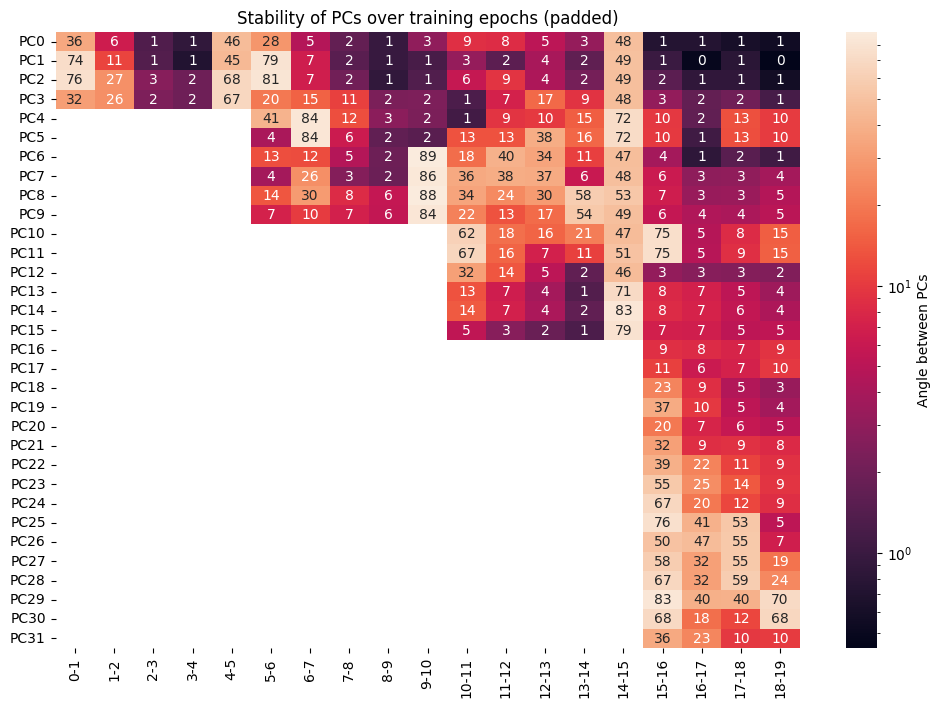

In [36]:
angle_matrix = np.zeros((len(padded_angle_dict), len(all_epoch_pairs)))

# Fill matrix with angle data
for pc, epoch_data in padded_angle_dict.items():
    i = 0
    for epoch_pair in all_epoch_pairs:
        angle_matrix[pc, i] = epoch_data[epoch_pair]
        i += 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    angle_matrix, 
    annot=True, 
    fmt=".0f",
    norm=LogNorm(), 
    xticklabels=[f"{e1}-{e2}" for e1, e2 in all_epoch_pairs], 
    yticklabels=[f"PC{pc}" for pc in padded_angle_dict.keys()],
    cbar_kws={"label": "Angle between PCs"})
ax.set_title("Stability of PCs over training epochs (padded)")
plt.show()

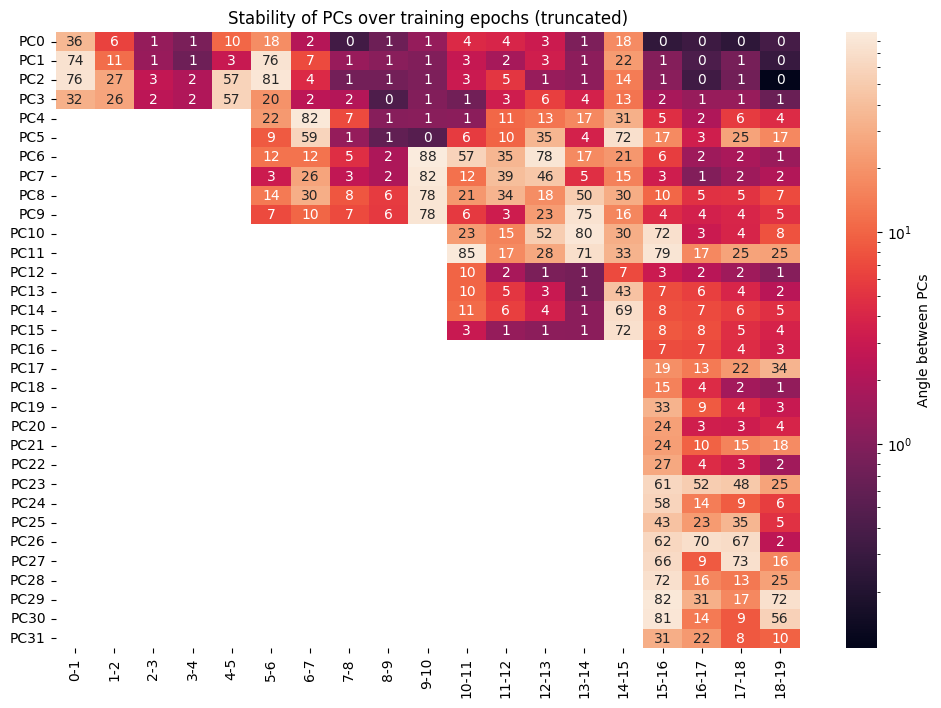

In [37]:

angle_matrix = np.zeros((len(truncated_angle_dict), len(all_epoch_pairs)))

# Fill matrix with angle data
for pc, epoch_data in truncated_angle_dict.items():
    i = 0
    for epoch_pair in all_epoch_pairs:
        angle_matrix[pc, i] = epoch_data[epoch_pair]
        i += 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    angle_matrix, 
    annot=True, 
    fmt=".0f",
    norm=LogNorm(), 
    xticklabels=[f"{e1}-{e2}" for e1, e2 in all_epoch_pairs], 
    yticklabels=[f"PC{pc}" for pc in truncated_angle_dict.keys()],
    cbar_kws={"label": "Angle between PCs"})
ax.set_title("Stability of PCs over training epochs (truncated)")
plt.show()